---
title: Classifying Palmer Penguins
author: Wright Frost
date: '2023-03-25'
description: 'Training a model to classify penguins'
format: html
---

# Why do we want to classify penguins?

I want to answer this question right off the bat. I think there are two answers: First, penguins are cool and cute. But more importantly, the process that we are going to use in this blog post is one that we can replicate for different datasets in the future. It doesn't *really* matter that the data we will classify is penguins - it could be for the titanic, or the iris dataset. What matters is understanding how to use different machine learning techniques to develop an accurate model for classifying our data. Maybe the model we use in this process isn't ideal for another dataset, or maybe we will need more than just 1 qualitative feature for a different dataset. However, the steps in this blog post are generally adaptable to a variety of situations.

With that out of the way, let's dive into it: first up is prepping our data so that it is ready for our model.

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

## Let's try to choose some good features.

I selected a Decision Tree Classifier for this process because I wanted to experiment with a new model. Using cross validation, I tried every possible different combination of 1 qualitative + 2 quantitative features, updating my list of top columns based on whichever yielded the highest mean score from the crossval subsets.

In [79]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)','Body Mass (g)']

top_score = 0
top_cols = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    # you could train models and score them here, keeping the list of 
    # columns for the model that has the best score. 
    cvs = cross_val_score(clf,X_train[cols],y_train,cv = 5)
    
    if cvs.mean() > top_score:
        top_cols = cols
        top_score = cvs.mean()

print(top_cols,top_score)

['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 0.9803921568627452


## Which qualitative features were selected?

It looks like islands are the best qualitative feature for fitting a classifier. Why is this?

We can filter our training data to see how many different islands the 3 species call home:

In [80]:
train.groupby("Species")["Island"].nunique()

Species
Adelie Penguin (Pygoscelis adeliae)          3
Chinstrap penguin (Pygoscelis antarctica)    1
Gentoo penguin (Pygoscelis papua)            1
Name: Island, dtype: int64

Interesting! So the Adelie Penguin is the only species on all three islands – Chinstrap and Gentoo are only on one each.

In [81]:
train[["Island","Species"]].groupby("Island").value_counts()

Island     Species                                  
Biscoe     Gentoo penguin (Pygoscelis papua)            101
           Adelie Penguin (Pygoscelis adeliae)           35
Dream      Chinstrap penguin (Pygoscelis antarctica)     56
           Adelie Penguin (Pygoscelis adeliae)           41
Torgersen  Adelie Penguin (Pygoscelis adeliae)           42
dtype: int64

The code above lets us break down the numbers by island. Torgerson has only Adelie Penguins, Dream has Chinstraps and Adelies, and Biscoe has Gentoos and Adelies. Based on this, it makes sense that island is the best qualitative feature to use in the model. Knowing which island we are considering instantly simplifes the selection process since we are only choosing between at most two species.

## Which quantitative features were selected?

Culmen length and depth were the two features selected. Let's see how these vary by species.

In [82]:
train[["Species","Culmen Length (mm)", "Culmen Depth (mm)"]].groupby("Species").mean()

,Culmen Length (mm),Culmen Depth (mm)
Species,,
Adelie Penguin (Pygoscelis adeliae),38.710256,18.365812
Chinstrap penguin (Pygoscelis antarctica),48.719643,18.442857
Gentoo penguin (Pygoscelis papua),47.757000,15.035000


<AxesSubplot: xlabel='Species'>

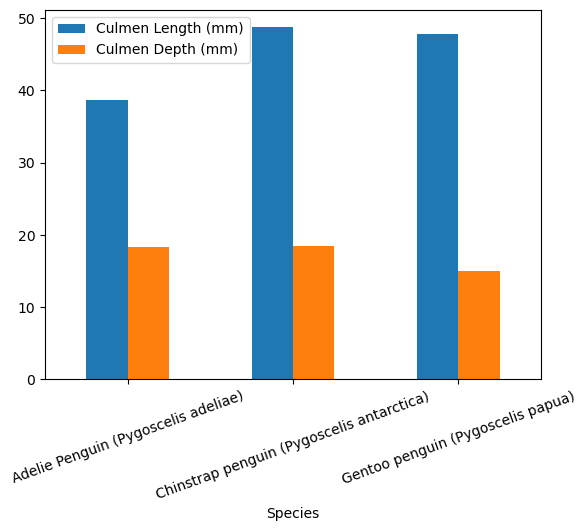

In [83]:
train[["Species","Culmen Length (mm)", "Culmen Depth (mm)"]].groupby("Species").mean().plot.bar(rot=20)

From here, we can clearly see that Adelie Penguins have the shortest culmens, while Chinstraps' culmens are slightly longer than Gentoos'. Gentoos have the smallest culmen depth, while Adelie and Chinstrap are fairly similar in culmen depth. When you consider that, once you know the island, you really only need to be able to distinguish between TWO species (Adelie + one of either Chinstrap or Gentoo), not between all three, it becomes clear that the differences in Culmen Length alone are probably sufficient to make a fairly accurate prediction. Culmen depth is another helpful feature to make the classifier even more accurate.

#### Just for my own curiosity, let's see if culmen length/depth varies by species by island.

Is a difference in environment enough to change the physical characteristics of a species? Or in this case, of one species, since Adelie penguins are the only ones to appear on more than one island?

In [84]:
train[["Island","Species","Culmen Length (mm)", "Culmen Depth (mm)"]].groupby(["Island","Species"]).mean()

Culmen Length (mm)  \
Island    Species                                                         
Biscoe    Adelie Penguin (Pygoscelis adeliae)                 38.674286   
          Gentoo penguin (Pygoscelis papua)                   47.757000   
Dream     Adelie Penguin (Pygoscelis adeliae)                 38.395122   
          Chinstrap penguin (Pygoscelis antarctica)           48.719643   
Torgersen Adelie Penguin (Pygoscelis adeliae)                 39.056098   

                                                     Culmen Depth (mm)  
Island    Species                                                       
Biscoe    Adelie Penguin (Pygoscelis adeliae)                18.228571  
          Gentoo penguin (Pygoscelis papua)                  15.035000  
Dream     Adelie Penguin (Pygoscelis adeliae)                18.319512  
          Chinstrap penguin (Pygoscelis antarctica)          18.442857  
Torgersen Adelie Penguin (Pygoscelis adeliae)                18.529268

It doesn't look like it, although Adelie Penguins' Culmen Lengths and Depths are both a tiny bit greater on Torgerson Island than the other two. Maybe the lack of competition from other penguins is responsible for the evolution of a special population of GIANT Adelie penguins on Torgerson. My takeaway is that in 1000 years, Torgerson Island's penguins will have ENORMOUS culmens.

But in all seriousness, no real difference here.

## Now we're ready to test our classifier...

Here, we read in the test data, then score our classifier on the test data filtered to contain only our selected features. We DO NOT fit the classifier to the testing data, because we want it to be scored based on the model trained on the training data. So we first fit it to the TRAINING data, then score it on the testing data.

In [85]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

clf.fit(X_train[top_cols],y_train)

X_test, y_test = prepare_data(test)
clf.score(X_test[top_cols],y_test)

0.9852941176470589

98.5% accuracy. Pretty close to perfect!

## How does the decision tree classifier actually work?

I adapted this technique from the scikit learn documentation page:
https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html

This shows us the depth of the tree, and how many samples remain to classify at each step. This tree has a depth of 4, which means it needs to make a maximum of 4 decisions to reach a classification for a sample.

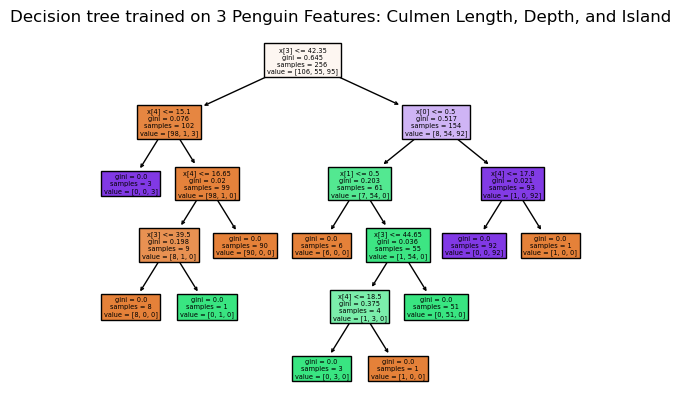

In [86]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plot_tree(clf, filled=True)
plt.title("Decision tree trained on 3 Penguin Features: Culmen Length, Depth, and Island")
plt.show()

## Now let's vizualize the decision regions of our model.

In [87]:
X_plot = X_test[top_cols]
qual_features = ["Island_Biscoe","Island_Dream","Island_Torgersen"]
x0 = X_plot[X_plot.columns[3]]
x1 = X_plot[X_plot.columns[4]]

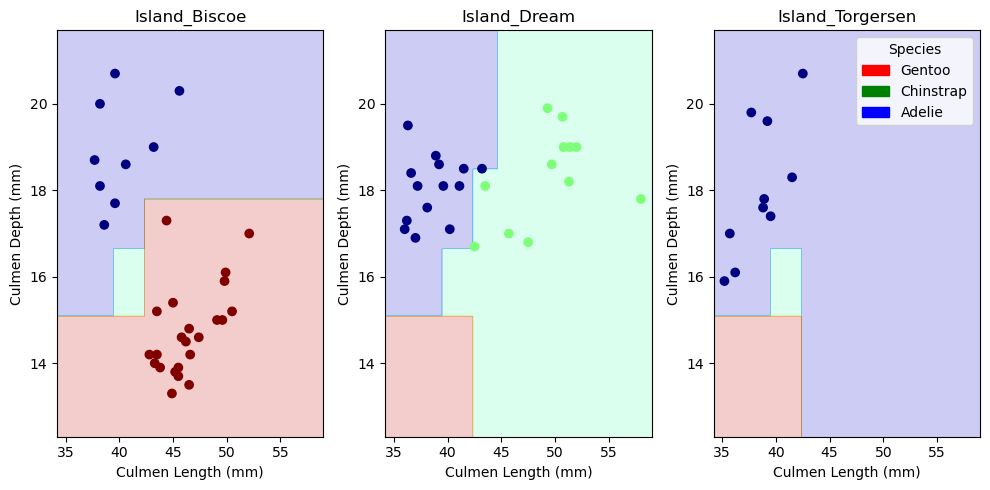

In [88]:
from matplotlib.patches import Patch
import numpy as np
import warnings

warnings.filterwarnings("ignore")

fig, axarr = plt.subplots(1, len(qual_features), figsize = (10, 5))

grid_x = np.linspace(x0.min() - 1,x0.max() + 1,501)
grid_y = np.linspace(x1.min() - 1,x1.max() + 1,501)
xx, yy = np.meshgrid(grid_x, grid_y)

XX = xx.ravel()
YY = yy.ravel()

for i in range(len(qual_features)):
    XY = pd.DataFrame({
      X_plot.columns[3] : XX,
      X_plot.columns[4] : YY
    })

    for j in qual_features[::-1]:
        XY.insert(0,j,0)

    XY[qual_features[i]] = 1
    
    p = clf.predict(XY.values)
    p = p.reshape(xx.shape)

    # use contour plot to visualize the predictions
    axarr[i].contourf(xx, yy, p, cmap='jet',alpha = 0.2,vmin = 0, vmax = 2)


    ix = X_plot[qual_features[i]] == 1
    # plot the data
    axarr[i].scatter(x0[ix], x1[ix], c = y_test[ix], cmap = "jet", vmin = 0, vmax = 2)
    axarr[i].set_title(label = qual_features[i])
    axarr[i].set(xlabel = X_plot.columns[3], 
        ylabel  = X_plot.columns[4])

    patches = []
    for color, spec in zip(["red", "green", "blue"], ["Gentoo", "Chinstrap", "Adelie"]):
        patches.append(Patch(color = color, label = spec))

        plt.legend(title = "Species", handles = patches, loc = "best")

        plt.tight_layout()

This is an interesting vizualization. It gives us a glimpse at the blocky nature of the decision tree classifer - rather than  separating these data with a single straight line, a Decision Tree Classifier almost breaks the plot up into rectangles. 

This is because the Decision Tree Classifer works by dividing along one of the two axes at each iteration of the fit process. So it can only divide vertically or horizontally. Over time, it makes smaller and more precise rectangular subsections that classify the data more and more accurately.

## Closing thoughts... Could this work well at a lower depth?

A simple test is to run our classifier with a lower depth and see how well it performs.

In [90]:
clf2 = DecisionTreeClassifier(max_depth = 4)
clf3 = DecisionTreeClassifier(max_depth = 3)

clf2.fit(X_train[top_cols], y_train)
score4 = clf2.score(X_test[top_cols], y_test)

clf3.fit(X_train[top_cols], y_train)
score3 = clf3.score(X_test[top_cols], y_test)

score4,score3

(0.9852941176470589, 0.9852941176470589)

In [92]:
score4 == score3

True

It looks like the classifier can run well at lower depths. The model still performs well at a depth of 4, and 3. However, even with the depth of five that the classifier automatically selected, the accuracy stays the same and there is no real gap between testing and training data. This means that the model is not overfit to the training data, so while the greater depth may not add anything, it doesn't detract from the model either.

In summary, this was an interesting process. Starting off knowing nothing about the distribution of the species or their physical characteristics, we were able to automate most of the process of building a model to classify them. This speaks to the power of machine learning and how quickly it can break down a complicated process to reach the desired end result. 

Obviously not every dataset can be 100% accurately classified as this penguin one could, but a process like this gets us pretty close.

And finally, to honor the three heroes of this blog post, here they are in all their glory:

<img src="licensed-image.jpg" width="50%"></img>
<em> Adelie Penguin </em>
[img source](https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin)

<img src="Chinstrap_Penguin.jpg"  width="50%"/></img>
<em>Chinstrap Penguin</em>
[img source](https://en.wikipedia.org/wiki/Chinstrap_penguin)

<img src="Gentoo.jpg"  width="50%"/></img>
<em>Gentoo Penguin </em>
[img source](https://en.wikipedia.org/wiki/File:Brown_Bluff-2016-Tabarin_Peninsula%E2%80%93Gentoo_penguin_(Pygoscelis_papua)_03.jpg)







